In [1]:
import torch
from torch import nn
from torchvision import transforms
from torchvision import models
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageFilter
from PIL import ImageOps
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from copy import copy
from copy import deepcopy
import sys
import os
import cv2
import pandas as pd
import numpy as np
import random
from pathlib import Path

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' # dead kernel for matplotlib

In [2]:
metadata = pd.read_csv('../doby_meta.csv')
metadata = metadata[metadata['subject_id'] < 16000000]
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4198 entries, 0 to 4197
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   subject_id      4198 non-null   int64 
 1   study_id        4198 non-null   int64 
 2   dicom_id        4198 non-null   object
 3   DicomPath       4198 non-null   object
 4   edema_severity  4198 non-null   int64 
 5   normal          4198 non-null   int64 
 6   CHF             4198 non-null   bool  
dtypes: bool(1), int64(4), object(2)
memory usage: 233.7+ KB


In [3]:
SEG_BASE_PATH = '../chest-x-ray-dataset-with-lung-segmentation-1.0.0/chest-x-ray-dataset-with-lung-segmentation-1.0.0'
ORIG_BASE_PATH = '../physionet.org/files/mimic-cxr-jpg/2.0.0'

In [4]:
TRANSFORMS = transforms.Compose([
    transforms.ToTensor()
])

In [5]:
class MixDataset(Dataset):
    def __init__(self, metadata, seg_base_path, orig_base_path, transform=None):
        self.metadata = metadata
        self.seg_base_path = Path(seg_base_path)
        self.orig_base_path = Path(orig_base_path)
        self.transform = transform

    def __getitem__(self, idx):
        x_path = self.metadata.loc[idx, 'DicomPath']
        x_seg_path = self.seg_base_path / Path(x_path)
        x_orig_path = self.orig_base_path / Path(x_path)
        
        x_seg = Image.open(x_seg_path).convert('L') # convert를 하지 않으면, ToTensor를 할 때, 3x224x224로 바꾼다.
        x_orig_ = Image.open(x_orig_path).convert('L').resize(x_seg.size)

        '''
        plt.subplot(2, 2, 1)
        plt.imshow(x_orig, cmap='gray')
        plt.axis('off')
                    
        plt.subplot(2, 2, 2)
        plt.imshow(x_seg, cmap='gray')
        plt.axis('off')
        '''
        
        x_orig = x_orig_.filter(ImageFilter.GaussianBlur(1))

        '''
        plt.subplot(2, 2, 3)
        plt.imshow(x_orig, cmap='gray')
        plt.axis('off')
        '''

        x_mix = Image.blend(x_orig, x_seg, 0.2)

        # Histogram Equalization
        # x_mix = ImageOps.equalize(x_mix)

        '''
        plt.subplot(2, 2, 4)
        plt.imshow(x_mix, cmap='gray')
        plt.axis('off')
        plt.show()
        '''
        
        y = self.metadata.loc[idx, 'normal']

        if self.transform:
            x = self.transform(x_mix)

        return (x_orig_, x), y

    def __len__(self):
        return self.metadata['normal'].count()

In [14]:
class MergeDataset(Dataset):
    def __init__(self, metadata, seg_base_path, orig_base_path, transform=None):
        self.metadata = metadata
        self.seg_base_path = Path(seg_base_path)
        self.orig_base_path = Path(orig_base_path)
        self.transform = transform

    def __getitem__(self, idx):
        x_path = self.metadata.loc[idx, 'DicomPath']
        x_seg_mask_path = self.seg_base_path / Path(x_path[:-4] + '-mask.jpg')
        x_seg_path = self.seg_base_path / Path(x_path)
        x_orig_path = self.orig_base_path / Path(x_path)

        x_seg = cv2.imread(str(x_seg_path), cv2.IMREAD_GRAYSCALE)
        x_seg_mask = cv2.imread(str(x_seg_mask_path), cv2.IMREAD_GRAYSCALE)
        x_orig = cv2.imread(str(x_orig_path), cv2.IMREAD_GRAYSCALE)
        x_orig = cv2.resize(x_orig, dsize=(224, 224), interpolation=cv2.INTER_AREA)

        # 노이즈 제거
        seg_mask1 = np.where(x_seg_mask > 128, 1, 0) # 128 threshold
        # 반전 마스크 및 노이즈 제거
        seg_mask2 = np.where(x_seg_mask < 128, 1, 0) # 128 threshold

        x_lung_seg = x_orig*seg_mask1

        # Gaussian Blur 적용
        x_orig_blur = Image.fromarray(x_orig).convert('L')
        x_orig_blur = x_orig_blur.filter(ImageFilter.GaussianBlur(1))
        x_orig_blur = np.array(x_orig_blur)

        # Lung Segmentation 제외 제거
        x_background = x_orig_blur*seg_mask2 # lung segmentation 제외 비우기
        x_background_ = copy(x_background)
        seg_mask3 = np.where(x_seg_mask > 128, 255, 0).astype(np.uint8) # 타입 CV_8U 오류 방지

        # Background에 Lung Segmentation 붙이기
        x_merge = cv2.copyTo(x_lung_seg, seg_mask3, x_background)
        x_merge = Image.fromarray(x_merge).convert('L')
        
        # Histogram Equalization
        # x_merge = ImageOps.equalize(x_merge)
        
        y = self.metadata.loc[idx, 'normal']

        if self.transform:
            x = self.transform(x_merge)

        return (x_orig, x_background_, x_seg, x), y

    def __len__(self):
        return self.metadata['normal'].count()

In [15]:
mix_ds = MixDataset(metadata, SEG_BASE_PATH, ORIG_BASE_PATH, transform=TRANSFORMS)

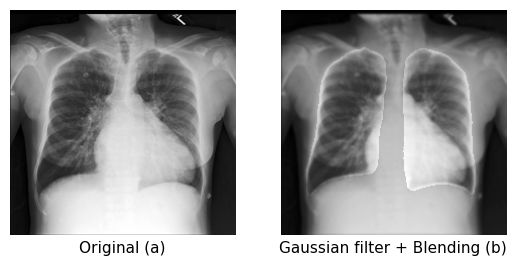

In [16]:
from torchvision.transforms.functional import to_pil_image

(x_orig, x), y = mix_ds[104]
plt.subplot(1, 2, 1)
plt.imshow(x_orig, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('Original (a)', fontsize=11)

plt.subplot(1, 2, 2)
plt.imshow(to_pil_image(x), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('Gaussian filter + Blending (b)', fontsize=11)

plt.show()
# plt.savefig('./figure3.jpg', dpi=500, pad_inches=0)

In [17]:
merge_ds = MergeDataset(metadata, SEG_BASE_PATH, ORIG_BASE_PATH, transform=TRANSFORMS)

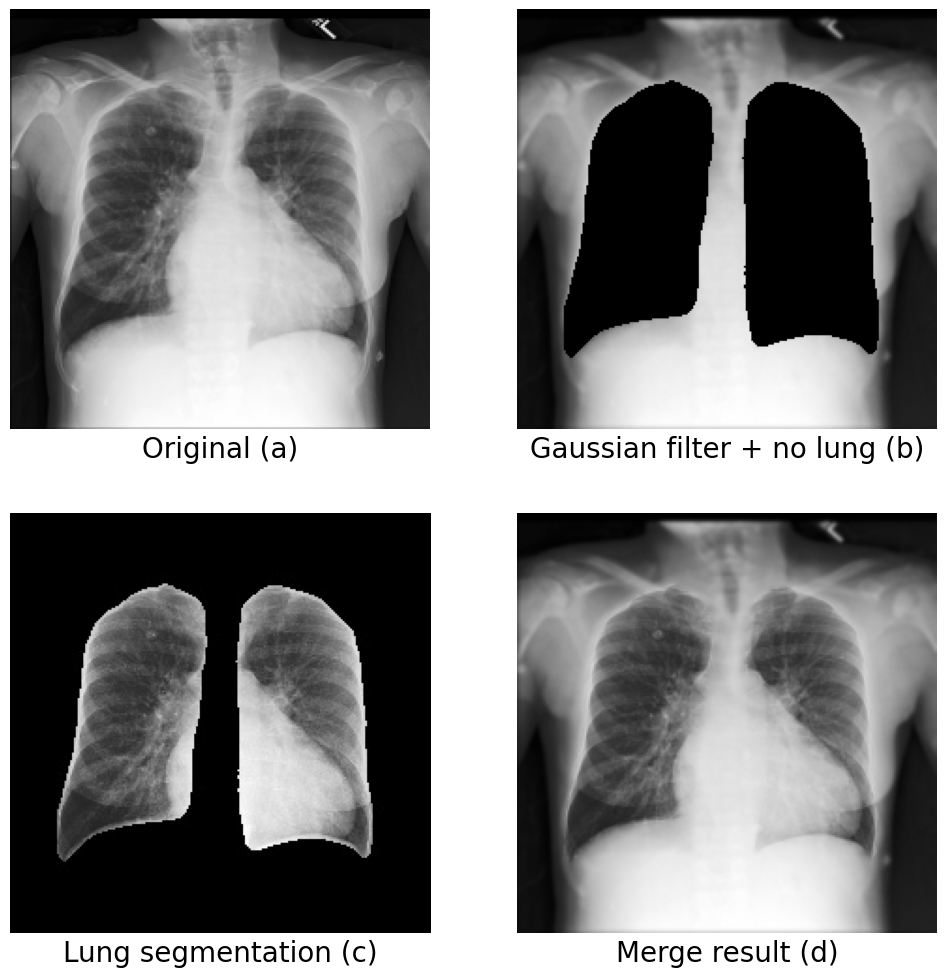

In [19]:
(x_orig, x_back, x_seg, x), y = merge_ds[104]

plt.figure(figsize=(12, 12))
fs = 20

plt.subplot(2, 2, 1)
plt.imshow(to_pil_image(x_orig), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('Original (a)', fontsize=fs)

plt.subplot(2, 2, 2)
plt.imshow(x_back, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('Gaussian filter + no lung (b)', fontsize=fs)

plt.subplot(2, 2, 3)
plt.imshow(x_seg, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('Lung segmentation (c)', fontsize=fs)

plt.subplot(2, 2, 4)
plt.imshow(to_pil_image(x), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('Merge result (d)', fontsize=fs)

plt.savefig('./revision_figure5.jpg', dpi=500, pad_inches=0)
plt.show()